In [53]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split

from data import generate_data, generate_observation_matrix
from loss import create_mc_loss
from network import init_net, init_bm, compute_end_to_end_bm, compute_end_to_end, compute_factor, compress_network
from solver import train, compute_dlr
from utils import compose, svd

## CompDMF

In [64]:
key = PRNGKey(0)

# Generate data
r = 50
d = 5000
depth = 3
init_type = "orth"
init_scale = 1e-1

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
init_weights = init_net(key=subkey, input_dim=d, output_dim=d, width=d, depth=depth, init_type=init_type, init_scale=init_scale)

key, subkey = split(key)
percent_observed = 0.20
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))
masked_target = mask * target

train_mc_loss_fn = create_mc_loss(target, mask)
test_mc_loss_fn = create_mc_loss(target, 1 - mask)

tol = 1e-14
n_outer_loops = 1000
n_inner_loops = 1

In [55]:
comp_train_e2e_loss_fn = compose(train_mc_loss_fn, compute_end_to_end)
comp_test_e2e_loss_fn = compose(test_mc_loss_fn, compute_end_to_end)

V = compute_factor(init_weights=init_weights, e2e_loss_fn=comp_train_e2e_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights, V, r)

In [65]:
comp_step_size = compute_dlr(step_size=1e5, depth=len(comp_init_weights), prop=0.01)

comp_result = train(
    init_weights=comp_init_weights,
    train_e2e_loss_fn=comp_train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=comp_step_size,
    test_e2e_loss_fn=comp_test_e2e_loss_fn,
    tol=tol,
    n_inner_loops=n_inner_loops
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## GDSpecInit

In [57]:
gd_train_e2e_loss_fn = compose(train_mc_loss_fn, compute_end_to_end_bm)
gd_test_e2e_loss_fn = compose(test_mc_loss_fn, compute_end_to_end_bm)

gd_init_weights = init_bm(masked_target, r)

In [66]:
gd_step_size = 1e6

gd_result = train(
    init_weights=gd_init_weights,
    train_e2e_loss_fn=gd_train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=gd_step_size,
    test_e2e_loss_fn=gd_test_e2e_loss_fn,
    tol=tol,
    n_inner_loops=n_inner_loops
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## GDSpecInit

In [67]:
pgd_step_size = 1e7

pgd_result = train(
    init_weights=gd_init_weights,
    train_e2e_loss_fn=gd_train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=pgd_step_size,
    test_e2e_loss_fn=gd_test_e2e_loss_fn,
    tol=tol,
    precond=True,
    n_inner_loops=n_inner_loops
)

  0%|          | 0/1000 [00:00<?, ?it/s]

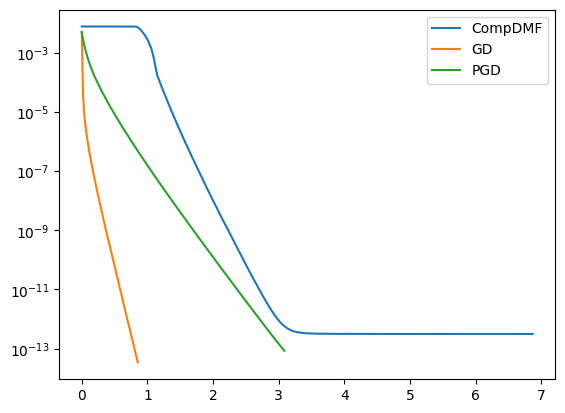

In [68]:
plt.semilogy(comp_result['time'], comp_result['test_loss'], label='CompDMF')
plt.semilogy(gd_result['time'], gd_result['test_loss'], label='GD')
plt.semilogy(pgd_result['time'], pgd_result['test_loss'], label='PGD')
plt.legend()